In this notebook, we create the melspectograms that will be the instances for the convolutional neural net we're working towards.

The idea for the creation of the melspectograms in this notebook is described [here](https://github.com/josafatburmeister/BirdSongIdentification/tree/main#stage-2-spectrogram-creation) and we adopt code from the `spec.py` and `utils/audio.py` files of this [Github repository](https://github.com/jimmy133719/BirdCLEF2019/tree/master)

In [1]:
# Imports
import os
import pathlib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import cv2

In [2]:
# Helper function to display images (replaces cv2_imshow from Colab)
def show_spec(img):
    """Display a spectrogram image using matplotlib"""
    plt.figure(figsize=(10, 4))
    plt.imshow(img, cmap='gray', aspect='auto')
    plt.axis('off')
    plt.show()

In [3]:
# Setup paths - using relative path from notebooks/ to Data/
DATA_DIR = pathlib.Path('..') / 'Data'
audio_dir = str(DATA_DIR / 'phaethornis_audio')

In [4]:
md = pd.read_csv(DATA_DIR / "phaethornis_metadata.csv")

In [5]:
md.columns

Index(['id', 'gen', 'sp', 'ssp', 'grp', 'en', 'rec', 'cnt', 'loc', 'lat',
       'lon', 'alt', 'type', 'sex', 'stage', 'method', 'url', 'file',
       'file-name', 'sono', 'osci', 'lic', 'q', 'length', 'time', 'date',
       'uploaded', 'also', 'rmk', 'animal-seen', 'playback-used', 'temp',
       'regnr', 'auto', 'dvc', 'mic', 'smp'],
      dtype='object')

In [6]:
def melspec(sig, rate, shape, fmin=500, fmax=15000, normalize=True, preemphasis=0.95):
    """
    Given wave form (`sig` and `rate`), produce melspectrogram with dimensions `shape`
    """

    # shape = (height, width) in pixels

    # Mel-Spec parameters
    SAMPLE_RATE = rate
    N_FFT = 8*shape[0]  # = window length
    N_MELS = shape[0]
    HOP_LEN = len(sig) // (shape[1] - 1)
    #print('hop len = ' + str(HOP_LEN))
    FMAX = fmax
    FMIN = fmin

    # Preemphasis as in python_speech_features by James Lyons
    # See also https://math.stackexchange.com/questions/44216/speech-processing-pre-emphasis-how-does-it-work
    if preemphasis:
        sig = np.append(sig[0], sig[1:] - preemphasis * sig[:-1])

    # Librosa mel-spectrum
    melspec = librosa.feature.melspectrogram(y=sig, sr=SAMPLE_RATE, hop_length=HOP_LEN, n_fft=N_FFT, n_mels=N_MELS, fmax=FMAX, fmin=FMIN, power=1.0)

    # Convert power spec to dB scale (compute dB relative to peak power)
    melspec = librosa.amplitude_to_db(melspec, ref=np.max, top_db=80)

    # Flip spectrum vertically (only for better visialization, low freq. at bottom)
    melspec = melspec[::-1, ...]
    #print(melspec.shape)

    # Trim to desired shape if too large
    melspec = melspec[:shape[0], :shape[1]]

    # Normalize values between 0 and 1
    if normalize:
        melspec -= melspec.min()
        if not melspec.max() == 0:
            melspec /= melspec.max()
        else:
            melspec = np.clip(melspec, 0, 1)

    return melspec.astype('float32')

In [7]:
def specsFromFile(path, shape=(128, 256), rate = 44_100, seconds=5, overlap=4, minlen=3, **kwargs):
    """
    Split signal into chunks of duration `seconds` (with overlap of `overlap` among consecutive chunks)
    Yield a melspectrogram for each chunk
    """
    #open audio file
    sig, rate = librosa.load(path, sr=rate, offset=None)
    print("SampleRate of audio:", rate)

    #split signal with ovelap
    sig_splits = []
    for i in range(0, len(sig), int((seconds - overlap) * rate)):
        split = sig[i:i + int(seconds * rate)]
        if len(split) >= minlen * rate:
            sig_splits.append(split)

    #is signal too short for segmentation?
    #append it anyway
    if len(sig_splits) == 0:
        sig_splits.append(sig)

    for sig in sig_splits:

        # Get spec for signal chunk
        spec = melspec(sig, rate, shape, **kwargs)

        yield spec

In [8]:
def signal2noise(spec):
    """
    Given a melspectrogram, gets ratio of signal to noise--taken from https://github.com/jimmy133719/BirdCLEF2019/blob/master/utils/audio.py
    """
    # Get working copy
    spec = spec.copy()

    # Calculate median for columns and rows
    col_median = np.median(spec, axis=0, keepdims=True)
    row_median = np.median(spec, axis=1, keepdims=True)

    # Binary threshold
    spec[spec < row_median * 1.25] = 0.0
    spec[spec < col_median * 1.15] = 0.0
    spec[spec > 0] = 1.0
    # show_spec(spec*255)  # Uncomment to visualize

    # Median blur
    spec = cv2.medianBlur(spec, 3)
    # show_spec(spec*255)  # Uncomment to visualize

    # Morphology
    spec = cv2.morphologyEx(spec, cv2.MORPH_CLOSE, np.ones((3, 3), np.float32))
    # show_spec(spec*255)  # Uncomment to visualize

    # Sum of all values
    spec_sum = spec.sum()

    # Signal to noise ratio (higher is better)
    try:
        s2n = spec_sum / (spec.shape[0] * spec.shape[1] * spec.shape[2])
    except:
        s2n = spec_sum / (spec.shape[0] * spec.shape[1])

    return s2n

## Example of chunking



Here are all the audio files for the syrmatophorus species

In [9]:
pd.set_option('display.max_rows', None)
display(md.loc[(md['sp'] == "augusti"), ["id","q", "type", "rec", "also"]])
pd.set_option('display.max_rows', 10)


,id,q,type,rec,also
451,205383,no score,call,Sergio Chaparro-Herrera,[]
452,856810,A,song,David Monroy Rengifo,[]
453,782121,A,call,Carlos Verea,"['Chalybura buffonii', 'Stelgidopteryx ruficol..."
454,782016,A,call,Carlos Verea,[]
455,457500,A,song,GABRIEL LEITE,[]
456,407865,A,song,Daniel de Jesus Garcia,[]
457,254135,A,call,Joe Klaiber,[]
458,254132,A,song,Joe Klaiber,[]
459,246945,A,song,Joe Klaiber,[]
460,197455,A,song,Joe Klaiber,[]


We will show the 1 second chunks we get from the 254135.mp3 audio file and their corresponding signal to noise ratios.

SampleRate of audio: 44100


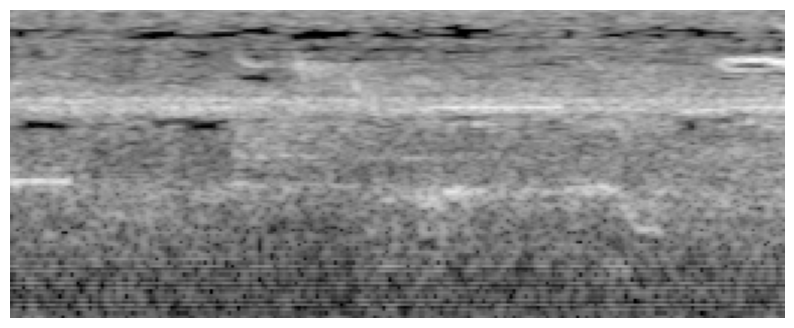

signal to noise ratio: 0.01416015625


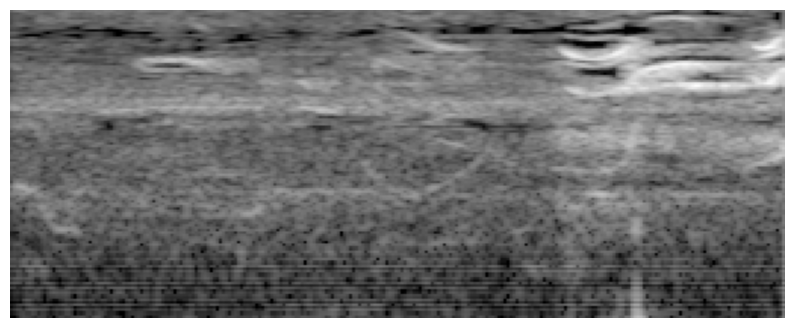

signal to noise ratio: 0.075714111328125


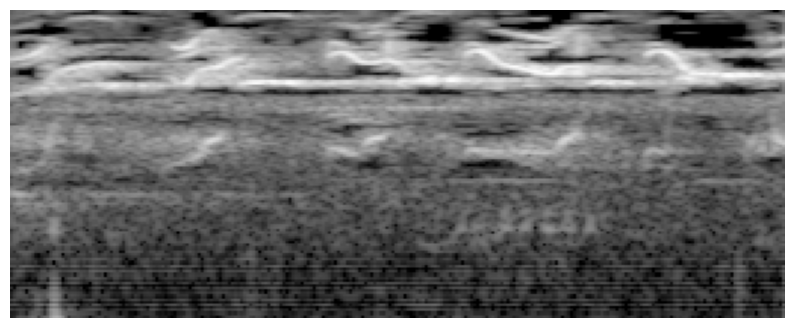

signal to noise ratio: 0.074432373046875


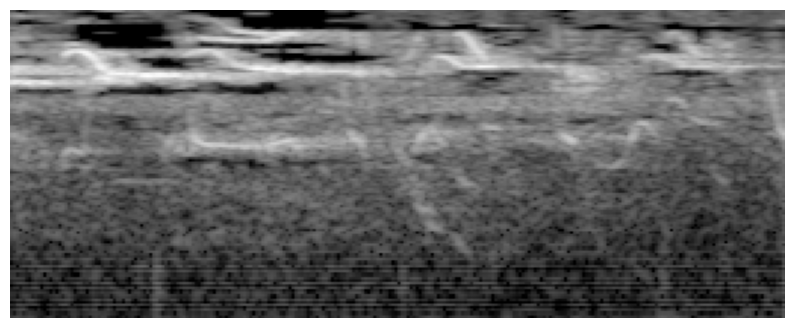

signal to noise ratio: 0.064361572265625


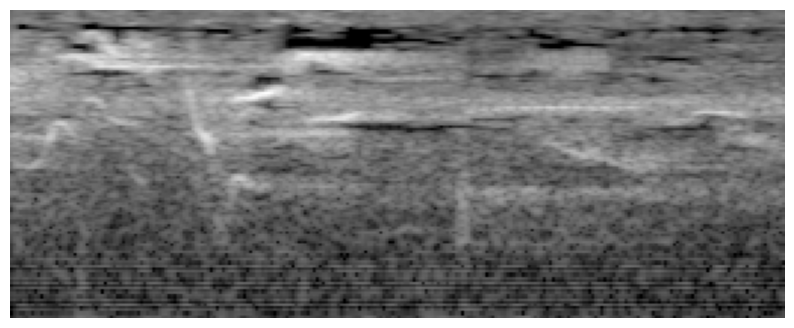

signal to noise ratio: 0.0574951171875


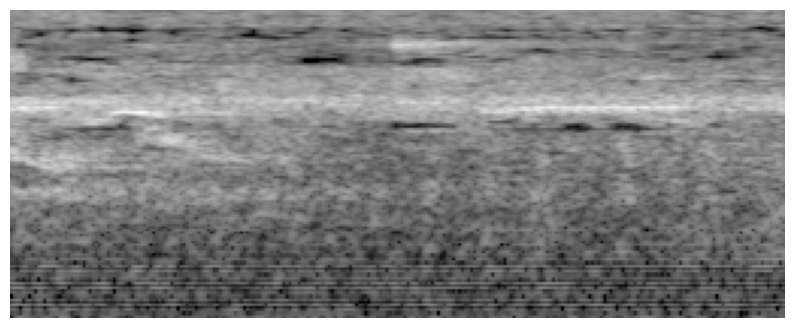

signal to noise ratio: 0.0186767578125


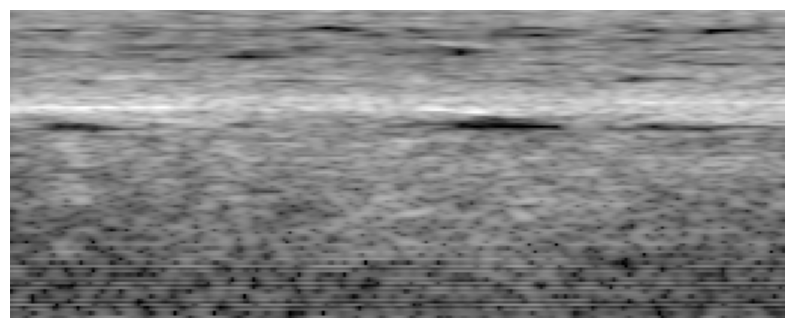

signal to noise ratio: 0.007232666015625


In [10]:
label = 'augusti'
filename = '254135.mp3'
audio_file_path = os.path.join(audio_dir, label, filename)
cnt = 0
for spec in specsFromFile(audio_file_path, seconds=1, overlap=0.25, minlen=.5):
    # if cnt > 10:
    #   break
    show_spec(spec*255)
    s2n = signal2noise(spec)
    print(f"signal to noise ratio: {s2n}")
    cnt += 1

## Actually download spectrograms

In [11]:
# the following choices are mostly based on https://github.com/jimmy133719/BirdCLEF2019/blob/master/utils/audio.py
SAMPLE_RATE = 44_100
SPEC_LENGTH = 1
SPEC_OVERLAP = 0.25 #some overlap
SPEC_MINLEN = 1.0
SPEC_FMIN = 500
SPEC_FMAX = 15000
IM_SIZE = (256, 128) #(width, height)

def getSpecs(path, random):
    """
    Wrapper around specFromFile that returns two lists:
      - List of spectrograms (corresponding to chunks of the audio file at path)
      - List of the corresponding signal-to-noise ratios
    """
    specs = []
    s2ns = []

    # Get mel-specs for file
    for spec in specsFromFile(path,
                              shape=(IM_SIZE[1], IM_SIZE[0]),
                              rate=SAMPLE_RATE,
                              seconds=SPEC_LENGTH,
                              overlap=SPEC_OVERLAP,
                              minlen=SPEC_MINLEN,
                              fmin=SPEC_FMIN,
                              fmax=SPEC_FMAX):

        # Determine signal to noise ratio
        s2n = signal2noise(spec)
        specs.append(spec)
        s2ns.append(s2n)

    return specs, s2ns

In [12]:
def parseDataset(src_dir, good_dir, noise_dir, rng, classes = None,
                 quals = ["A", "B"], n_keep = 4):
    """
    - We parse the specified classes (default is None, in which case we parse
    all the classes found as names of subdirectories in `src_dir`)
    - We only parse audio files that have a quality grade (md.q) in `quals`
    - When parsing a single audio file, we chunk it up and create spectrogram from each chunk
      The argument `n_keep` determines how many of these spectrograms we keep.
      Specifically, we keep the chunks with the top `n_keep` signal to noise ratios.
    """

    #This dictionary will store the file names of each spectrogram we create
    spec_all = {}

    # List of classes (the subfolders are class names)
    if classes is None:
      classes = sorted(os.listdir(src_dir))

    # Parse every class
    for c in classes:

        #Create directories for storing spectograms from class c
        good_label_path = os.path.join(good_dir, c)
        noise_label_path = os.path.join(noise_dir, c)
        if not os.path.exists(good_label_path):
          os.makedirs(good_label_path)
        if not os.path.exists(noise_label_path):
          os.makedirs(noise_label_path)

        #Create a dictionary for storing the file names of spectrograms from class c
        spec_all[c] = {"good" : [], "noisy" : []}

        #List of audio files from class c(filtered to only include high quality audio)
        ids = md.loc[(md['sp'] == c)& (md['q'].isin(quals)),"id"].tolist()
        afiles = [str(id)+".mp3" for id in ids]

        # Loop through audio files
        for i in range(len(afiles)):

            # Stats
            print(i + 1, '/', len(afiles), c, afiles[i])

            # Get the list of spectograms and signal to noise ratios for each chunk of the audio file
            try:
                specs, s2ns = getSpecs(os.path.join(audio_dir, c, afiles[i]), random)
            except FileNotFoundError as e:
                print(f"Issue parsing class {c}, audio file {afiles[i]}: {e}")
                continue

            # Save spectrograms of chunks with the most signal
            max_idxs = np.argsort(s2ns)[-n_keep:]
            for chunk_id in max_idxs:
              # Filename of form fileid_chunkid_s2n
              filename = afiles[i].split('.')[0] + '_' + str(chunk_id).zfill(3) + "_" + str(int(s2ns[chunk_id] * 10000)).zfill(4)
              spec_all[c]["good"].append(filename)
              cv2.imwrite(os.path.join(good_label_path, filename + '.png'), specs[chunk_id] * 255.0)

            # save some noisy spectrograms
            noisy_idxs = [idx for idx in range(len(specs)) if idx not in max_idxs]
            sampled_noisy_idxs = rng.choice(noisy_idxs, size = int(.1*len(noisy_idxs)))
            for chunk_id in sampled_noisy_idxs:
                # Filename will be of form fileid_chunkid_s2n
                filename = afiles[i].split('.')[0] + '_' + str(chunk_id).zfill(3) + "_" + str(int(s2ns[chunk_id] * 10000)).zfill(4)
                spec_all[c]["noisy"].append(filename)
                cv2.imwrite(os.path.join(noise_label_path, filename + '.png'), specs[chunk_id] * 255.0)



In [13]:
noise_dir = str(DATA_DIR / "phaethornis_noisyspecs")
good_dir = str(DATA_DIR / 'phaethornis_goodspecs')

if not os.path.exists(noise_dir):
    os.makedirs(noise_dir)
if not os.path.exists(good_dir):
    os.makedirs(good_dir)

rng = np.random.default_rng(420)
parseDataset(audio_dir, good_dir, noise_dir, rng=rng)

1 / 6 aethopygus 654652.mp3
SampleRate of audio: 44100


[ WARN:0@31.088] global loadsave.cpp:1063 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


2 / 6 aethopygus 149950.mp3
SampleRate of audio: 44100
3 / 6 aethopygus 36955.mp3
SampleRate of audio: 44100
4 / 6 aethopygus 510485.mp3
SampleRate of audio: 44100
5 / 6 aethopygus 91208.mp3
SampleRate of audio: 44100
6 / 6 aethopygus 90519.mp3
SampleRate of audio: 44100
1 / 10 anthophilus 537301.mp3
SampleRate of audio: 44100
2 / 10 anthophilus 537299.mp3
SampleRate of audio: 44100
3 / 10 anthophilus 353928.mp3
SampleRate of audio: 44100
4 / 10 anthophilus 245308.mp3
SampleRate of audio: 44100
5 / 10 anthophilus 148052.mp3
SampleRate of audio: 44100
6 / 10 anthophilus 127603.mp3
SampleRate of audio: 44100
7 / 10 anthophilus 360334.mp3
SampleRate of audio: 44100
8 / 10 anthophilus 343326.mp3
SampleRate of audio: 44100
9 / 10 anthophilus 245221.mp3
SampleRate of audio: 44100
10 / 10 anthophilus 14592.mp3
SampleRate of audio: 44100
1 / 8 atrimentalis 706546.mp3
SampleRate of audio: 44100
2 / 8 atrimentalis 683914.mp3
SampleRate of audio: 44100
3 / 8 atrimentalis 257801.mp3
SampleRate of 

/var/folders/9q/mksbnvwd5tx0bflrq95_yfs00000gn/T/ipykernel_70127/2750170014.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  sig, rate = librosa.load(path, sr=rate, offset=None)
/Users/shrinaath/Deep_learning_Birds/venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


7 / 8 atrimentalis 270894.mp3
SampleRate of audio: 44100
8 / 8 atrimentalis 238795.mp3
SampleRate of audio: 44100
1 / 13 augusti 856810.mp3
Issue parsing class augusti, audio file 856810.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/augusti/856810.mp3'
2 / 13 augusti 782121.mp3
SampleRate of audio: 44100
3 / 13 augusti 782016.mp3
SampleRate of audio: 44100
4 / 13 augusti 457500.mp3
SampleRate of audio: 44100
5 / 13 augusti 407865.mp3
SampleRate of audio: 44100
6 / 13 augusti 254135.mp3
SampleRate of audio: 44100
7 / 13 augusti 254132.mp3
SampleRate of audio: 44100


Note: Illegal Audio-MPEG-Header 0x50455441 at offset 340971.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


8 / 13 augusti 246945.mp3
SampleRate of audio: 44100
9 / 13 augusti 197455.mp3
SampleRate of audio: 44100
10 / 13 augusti 27923.mp3
SampleRate of audio: 44100
11 / 13 augusti 856805.mp3
Issue parsing class augusti, audio file 856805.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/augusti/856805.mp3'
12 / 13 augusti 254133.mp3
SampleRate of audio: 44100
13 / 13 augusti 22138.mp3
SampleRate of audio: 44100
1 / 39 bourcieri 986355.mp3
Issue parsing class bourcieri, audio file 986355.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/bourcieri/986355.mp3'
2 / 39 bourcieri 933937.mp3
Issue parsing class bourcieri, audio file 933937.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/bourcieri/933937.mp3'
3 / 39 bourcieri 827648.mp3
SampleRate of audio: 44100
4 / 39 bourcieri 478363.mp3
SampleRate of audio: 44100
5 / 39 bourcieri 437444.mp3
SampleRate of audio: 44100
6 / 39 bourcieri 431907.mp3
SampleRate of audio: 44100
7 / 39 bourcier

Note: Illegal Audio-MPEG-Header 0x20506175 at offset 530725.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x61692c20 at offset 1286186.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


17 / 106 eurynome 435611.mp3
SampleRate of audio: 44100


Note: Illegal Audio-MPEG-Header 0x69726169 at offset 920054.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


18 / 106 eurynome 427761.mp3
SampleRate of audio: 44100
19 / 106 eurynome 422962.mp3
SampleRate of audio: 44100
20 / 106 eurynome 416012.mp3
SampleRate of audio: 44100
21 / 106 eurynome 391830.mp3
SampleRate of audio: 44100
22 / 106 eurynome 391829.mp3
SampleRate of audio: 44100
23 / 106 eurynome 374225.mp3
SampleRate of audio: 44100
24 / 106 eurynome 344132.mp3
SampleRate of audio: 44100
25 / 106 eurynome 340958.mp3
SampleRate of audio: 44100
26 / 106 eurynome 333390.mp3
SampleRate of audio: 44100
27 / 106 eurynome 308985.mp3
SampleRate of audio: 44100
28 / 106 eurynome 304584.mp3
SampleRate of audio: 44100
29 / 106 eurynome 299642.mp3
SampleRate of audio: 44100
30 / 106 eurynome 232824.mp3
SampleRate of audio: 44100
31 / 106 eurynome 232821.mp3
SampleRate of audio: 44100
32 / 106 eurynome 232820.mp3
SampleRate of audio: 44100
33 / 106 eurynome 232817.mp3
SampleRate of audio: 44100
34 / 106 eurynome 232804.mp3
SampleRate of audio: 44100
35 / 106 eurynome 211682.mp3
SampleRate of audio

Note: Illegal Audio-MPEG-Header 0x50455441 at offset 585895.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


27 / 95 longirostris 31906.mp3
SampleRate of audio: 44100
28 / 95 longirostris 1036740.mp3
Issue parsing class longirostris, audio file 1036740.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/longirostris/1036740.mp3'
29 / 95 longirostris 989661.mp3
Issue parsing class longirostris, audio file 989661.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/longirostris/989661.mp3'
30 / 95 longirostris 796907.mp3
SampleRate of audio: 44100
31 / 95 longirostris 796275.mp3
SampleRate of audio: 44100
32 / 95 longirostris 698993.mp3
SampleRate of audio: 44100
33 / 95 longirostris 490055.mp3
SampleRate of audio: 44100
34 / 95 longirostris 490054.mp3
SampleRate of audio: 44100
35 / 95 longirostris 411247.mp3
SampleRate of audio: 44100
36 / 95 longirostris 402754.mp3
SampleRate of audio: 44100
37 / 95 longirostris 361039.mp3
SampleRate of audio: 44100
38 / 95 longirostris 308485.mp3
SampleRate of audio: 44100
39 / 95 longirostris 308316.mp3
SampleRate of audio:

3 / 20 nattereri 924686.mp3
SampleRate of audio: 44100
4 / 20 nattereri 768984.mp3
SampleRate of audio: 44100
5 / 20 nattereri 705346.mp3
SampleRate of audio: 44100
6 / 20 nattereri 674254.mp3
SampleRate of audio: 44100
7 / 20 nattereri 673072.mp3
SampleRate of audio: 44100
8 / 20 nattereri 432347.mp3
SampleRate of audio: 44100


Note: Illegal Audio-MPEG-Header 0xc2a3202d at offset 653605.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


9 / 20 nattereri 432340.mp3
SampleRate of audio: 44100


Note: Illegal Audio-MPEG-Header 0x61722020 at offset 1634764.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


10 / 20 nattereri 288643.mp3
SampleRate of audio: 44100
11 / 20 nattereri 287836.mp3
SampleRate of audio: 44100
12 / 20 nattereri 227612.mp3
SampleRate of audio: 44100
13 / 20 nattereri 227611.mp3
SampleRate of audio: 44100
14 / 20 nattereri 10042.mp3
SampleRate of audio: 44100
15 / 20 nattereri 358887.mp3
SampleRate of audio: 44100
16 / 20 nattereri 291218.mp3
SampleRate of audio: 44100
17 / 20 nattereri 85293.mp3
SampleRate of audio: 44100
18 / 20 nattereri 85292.mp3
SampleRate of audio: 44100
19 / 20 nattereri 74019.mp3
SampleRate of audio: 44100
20 / 20 nattereri 9593.mp3
SampleRate of audio: 44100


1 / 16 philippii 1044951.mp3
Issue parsing class philippii, audio file 1044951.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/philippii/1044951.mp3'
2 / 16 philippii 1044496.mp3
Issue parsing class philippii, audio file 1044496.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/philippii/1044496.mp3'
3 / 16 philippii 1044458.mp3
Issue parsing class philippii, audio file 1044458.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/philippii/1044458.mp3'
4 / 16 philippii 1044061.mp3
Issue parsing class philippii, audio file 1044061.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/philippii/1044061.mp3'
5 / 16 philippii 1044060.mp3
Issue parsing class philippii, audio file 1044060.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/philippii/1044060.mp3'
6 / 16 philippii 1044058.mp3
Issue parsing class philippii, audio file 1044058.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_aud

16 / 16 philippii 20619.mp3
SampleRate of audio: 44100
1 / 76 pretrei 1034539.mp3
Issue parsing class pretrei, audio file 1034539.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/pretrei/1034539.mp3'
2 / 76 pretrei 1030258.mp3
Issue parsing class pretrei, audio file 1030258.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/pretrei/1030258.mp3'
3 / 76 pretrei 1030257.mp3
Issue parsing class pretrei, audio file 1030257.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/pretrei/1030257.mp3'
4 / 76 pretrei 818335.mp3
SampleRate of audio: 44100
5 / 76 pretrei 817272.mp3
SampleRate of audio: 44100
6 / 76 pretrei 816977.mp3
SampleRate of audio: 44100
7 / 76 pretrei 816974.mp3
SampleRate of audio: 44100
8 / 76 pretrei 816955.mp3
SampleRate of audio: 44100
9 / 76 pretrei 813092.mp3
SampleRate of audio: 44100
10 / 76 pretrei 803714.mp3
SampleRate of audio: 44100
11 / 76 pretrei 800317.mp3
SampleRate of audio: 44100
12 / 76 pretrei 800303.m

Note: Illegal Audio-MPEG-Header 0xa1732c20 at offset 259887.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


60 / 76 pretrei 385425.mp3
SampleRate of audio: 44100
61 / 76 pretrei 345360.mp3
SampleRate of audio: 44100
62 / 76 pretrei 151159.mp3
SampleRate of audio: 44100
63 / 76 pretrei 150596.mp3
SampleRate of audio: 44100
64 / 76 pretrei 149105.mp3
SampleRate of audio: 44100
65 / 76 pretrei 142242.mp3
SampleRate of audio: 44100
66 / 76 pretrei 128421.mp3
SampleRate of audio: 44100
67 / 76 pretrei 108645.mp3
SampleRate of audio: 44100
68 / 76 pretrei 103646.mp3


SampleRate of audio: 44100
69 / 76 pretrei 85025.mp3
SampleRate of audio: 44100
70 / 76 pretrei 51336.mp3
SampleRate of audio: 44100
71 / 76 pretrei 29142.mp3
SampleRate of audio: 44100
72 / 76 pretrei 29141.mp3
SampleRate of audio: 44100
73 / 76 pretrei 17575.mp3
SampleRate of audio: 44100
74 / 76 pretrei 16812.mp3
SampleRate of audio: 44100
75 / 76 pretrei 10230.mp3
SampleRate of audio: 44100
76 / 76 pretrei 10050.mp3
SampleRate of audio: 44100
1 / 120 ruber 1044567.mp3
Issue parsing class ruber, audio file 1044567.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/ruber/1044567.mp3'
2 / 120 ruber 995494.mp3
Issue parsing class ruber, audio file 995494.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/ruber/995494.mp3'
3 / 120 ruber 986809.mp3
Issue parsing class ruber, audio file 986809.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/ruber/986809.mp3'
4 / 120 ruber 986354.mp3
Issue parsing class ruber, audio file 986354.mp3: 

12 / 120 ruber 769013.mp3
SampleRate of audio: 44100
13 / 120 ruber 755362.mp3
SampleRate of audio: 44100
14 / 120 ruber 754917.mp3
SampleRate of audio: 44100
15 / 120 ruber 743990.mp3
SampleRate of audio: 44100
16 / 120 ruber 742060.mp3
SampleRate of audio: 44100
17 / 120 ruber 741075.mp3
SampleRate of audio: 44100
18 / 120 ruber 729367.mp3
SampleRate of audio: 44100


19 / 120 ruber 727454.mp3
SampleRate of audio: 44100
20 / 120 ruber 710947.mp3
SampleRate of audio: 44100
21 / 120 ruber 697361.mp3
SampleRate of audio: 44100
22 / 120 ruber 697194.mp3
SampleRate of audio: 44100
23 / 120 ruber 697155.mp3
SampleRate of audio: 44100
24 / 120 ruber 697154.mp3
SampleRate of audio: 44100
25 / 120 ruber 661561.mp3
SampleRate of audio: 44100
26 / 120 ruber 578489.mp3
SampleRate of audio: 44100
27 / 120 ruber 573021.mp3
SampleRate of audio: 44100
28 / 120 ruber 562850.mp3
SampleRate of audio: 44100
29 / 120 ruber 556481.mp3
SampleRate of audio: 44100
30 / 120 ruber 530430.mp3
SampleRate of audio: 44100
31 / 120 ruber 524475.mp3
SampleRate of audio: 44100
32 / 120 ruber 504748.mp3
SampleRate of audio: 44100
33 / 120 ruber 490095.mp3
SampleRate of audio: 44100
34 / 120 ruber 471152.mp3
SampleRate of audio: 44100
35 / 120 ruber 454954.mp3
SampleRate of audio: 44100
36 / 120 ruber 435868.mp3
SampleRate of audio: 44100
37 / 120 ruber 377623.mp3
SampleRate of audio:

90 / 120 ruber 396161.mp3
SampleRate of audio: 44100
91 / 120 ruber 345421.mp3
SampleRate of audio: 44100
92 / 120 ruber 271984.mp3
SampleRate of audio: 44100
93 / 120 ruber 234997.mp3
SampleRate of audio: 44100
94 / 120 ruber 227592.mp3
SampleRate of audio: 44100
95 / 120 ruber 227591.mp3
SampleRate of audio: 44100
96 / 120 ruber 227590.mp3
SampleRate of audio: 44100
97 / 120 ruber 227589.mp3
SampleRate of audio: 44100
98 / 120 ruber 213031.mp3
SampleRate of audio: 44100
99 / 120 ruber 202727.mp3
SampleRate of audio: 44100
100 / 120 ruber 147169.mp3
SampleRate of audio: 44100
101 / 120 ruber 124126.mp3
SampleRate of audio: 44100
102 / 120 ruber 119431.mp3
SampleRate of audio: 44100
103 / 120 ruber 94467.mp3
SampleRate of audio: 44100
104 / 120 ruber 94466.mp3
SampleRate of audio: 44100
105 / 120 ruber 87413.mp3
SampleRate of audio: 44100
106 / 120 ruber 85300.mp3
SampleRate of audio: 44100
107 / 120 ruber 85299.mp3
SampleRate of audio: 44100
108 / 120 ruber 74026.mp3
SampleRate of aud

10 / 14 rupurumii 691654.mp3
SampleRate of audio: 44100
11 / 14 rupurumii 690835.mp3
SampleRate of audio: 44100
12 / 14 rupurumii 401519.mp3
SampleRate of audio: 44100
13 / 14 rupurumii 352105.mp3
SampleRate of audio: 44100
14 / 14 rupurumii 32065.mp3
SampleRate of audio: 44100
1 / 13 squalidus 836179.mp3
SampleRate of audio: 44100
2 / 13 squalidus 705796.mp3
SampleRate of audio: 44100
3 / 13 squalidus 555876.mp3
SampleRate of audio: 44100
4 / 13 squalidus 435591.mp3
SampleRate of audio: 44100
5 / 13 squalidus 189518.mp3
SampleRate of audio: 44100


Note: Illegal Audio-MPEG-Header 0x65697261 at offset 482451.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


6 / 13 squalidus 115184.mp3
SampleRate of audio: 44100
7 / 13 squalidus 85295.mp3
SampleRate of audio: 44100
8 / 13 squalidus 283495.mp3
SampleRate of audio: 44100
9 / 13 squalidus 187476.mp3
SampleRate of audio: 44100
10 / 13 squalidus 85298.mp3
SampleRate of audio: 44100
11 / 13 squalidus 85297.mp3
SampleRate of audio: 44100
12 / 13 squalidus 85296.mp3
SampleRate of audio: 44100
13 / 13 squalidus 46286.mp3
SampleRate of audio: 44100
1 / 89 striigularis 1025991.mp3
Issue parsing class striigularis, audio file 1025991.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/striigularis/1025991.mp3'
2 / 89 striigularis 971163.mp3
Issue parsing class striigularis, audio file 971163.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/striigularis/971163.mp3'
3 / 89 striigularis 877446.mp3
Issue parsing class striigularis, audio file 877446.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/striigularis/877446.mp3'
4 / 89 striigularis 870804.

9 / 89 striigularis 518510.mp3
SampleRate of audio: 44100
10 / 89 striigularis 518509.mp3
SampleRate of audio: 44100
11 / 89 striigularis 482545.mp3
SampleRate of audio: 44100
12 / 89 striigularis 482544.mp3
SampleRate of audio: 44100
13 / 89 striigularis 402746.mp3
SampleRate of audio: 44100
14 / 89 striigularis 402738.mp3
SampleRate of audio: 44100
15 / 89 striigularis 400110.mp3
SampleRate of audio: 44100
16 / 89 striigularis 378369.mp3
SampleRate of audio: 44100
17 / 89 striigularis 361707.mp3
SampleRate of audio: 44100
18 / 89 striigularis 275254.mp3
SampleRate of audio: 44100
19 / 89 striigularis 274600.mp3
SampleRate of audio: 44100
20 / 89 striigularis 274301.mp3
SampleRate of audio: 44100
21 / 89 striigularis 271501.mp3
SampleRate of audio: 44100
22 / 89 striigularis 271500.mp3
SampleRate of audio: 44100
23 / 89 striigularis 263481.mp3
SampleRate of audio: 44100
24 / 89 striigularis 261704.mp3
SampleRate of audio: 44100
25 / 89 striigularis 261703.mp3
SampleRate of audio: 4410

40 / 89 striigularis 227599.mp3
SampleRate of audio: 44100
41 / 89 striigularis 227598.mp3
SampleRate of audio: 44100
42 / 89 striigularis 154074.mp3
SampleRate of audio: 44100
43 / 89 striigularis 154073.mp3
SampleRate of audio: 44100
44 / 89 striigularis 140774.mp3
SampleRate of audio: 44100
45 / 89 striigularis 131935.mp3
SampleRate of audio: 44100
46 / 89 striigularis 131932.mp3
SampleRate of audio: 44100
47 / 89 striigularis 127185.mp3
SampleRate of audio: 44100
48 / 89 striigularis 70884.mp3
SampleRate of audio: 44100
49 / 89 striigularis 10386.mp3
SampleRate of audio: 44100
50 / 89 striigularis 10385.mp3
SampleRate of audio: 44100
51 / 89 striigularis 6611.mp3
SampleRate of audio: 44100
52 / 89 striigularis 5934.mp3
SampleRate of audio: 44100
53 / 89 striigularis 774304.mp3
SampleRate of audio: 44100
54 / 89 striigularis 774301.mp3
SampleRate of audio: 44100
55 / 89 striigularis 694421.mp3
SampleRate of audio: 44100
56 / 89 striigularis 694247.mp3
SampleRate of audio: 44100
57 /

59 / 89 striigularis 630887.mp3
SampleRate of audio: 44100
60 / 89 striigularis 541695.mp3
SampleRate of audio: 44100
61 / 89 striigularis 486439.mp3
SampleRate of audio: 44100
62 / 89 striigularis 459993.mp3
SampleRate of audio: 44100
63 / 89 striigularis 400091.mp3
SampleRate of audio: 44100
64 / 89 striigularis 400085.mp3
SampleRate of audio: 44100
65 / 89 striigularis 335803.mp3
SampleRate of audio: 44100
66 / 89 striigularis 321623.mp3
SampleRate of audio: 44100


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 953827.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


67 / 89 striigularis 308314.mp3
SampleRate of audio: 44100
68 / 89 striigularis 282415.mp3
SampleRate of audio: 44100
69 / 89 striigularis 275253.mp3
SampleRate of audio: 44100
70 / 89 striigularis 271502.mp3
SampleRate of audio: 44100
71 / 89 striigularis 251624.mp3
SampleRate of audio: 44100
72 / 89 striigularis 227609.mp3
SampleRate of audio: 44100
73 / 89 striigularis 227605.mp3
SampleRate of audio: 44100
74 / 89 striigularis 216474.mp3
SampleRate of audio: 44100
75 / 89 striigularis 212373.mp3
SampleRate of audio: 44100
76 / 89 striigularis 174340.mp3
SampleRate of audio: 44100
77 / 89 striigularis 154027.mp3
SampleRate of audio: 44100
78 / 89 striigularis 146498.mp3
SampleRate of audio: 44100
79 / 89 striigularis 122712.mp3
SampleRate of audio: 44100
80 / 89 striigularis 107208.mp3
SampleRate of audio: 44100
81 / 89 striigularis 107207.mp3
SampleRate of audio: 44100
82 / 89 striigularis 102605.mp3
SampleRate of audio: 44100
83 / 89 striigularis 98208.mp3
SampleRate of audio: 4410

Note: Illegal Audio-MPEG-Header 0x28506861 at offset 90196.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3334292c at offset 514425.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


38 / 48 superciliosus 401254.mp3
SampleRate of audio: 44100
39 / 48 superciliosus 401242.mp3
SampleRate of audio: 44100
40 / 48 superciliosus 272358.mp3
SampleRate of audio: 44100
41 / 48 superciliosus 271890.mp3
SampleRate of audio: 44100
42 / 48 superciliosus 227614.mp3
SampleRate of audio: 44100
43 / 48 superciliosus 123089.mp3
SampleRate of audio: 44100
44 / 48 superciliosus 119297.mp3
SampleRate of audio: 44100
45 / 48 superciliosus 85916.mp3
SampleRate of audio: 44100
46 / 48 superciliosus 49635.mp3
SampleRate of audio: 44100
47 / 48 superciliosus 30253.mp3
SampleRate of audio: 44100
48 / 48 superciliosus 24193.mp3
SampleRate of audio: 44100
1 / 52 syrmatophorus 992513.mp3
Issue parsing class syrmatophorus, audio file 992513.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/syrmatophorus/992513.mp3'
2 / 52 syrmatophorus 992510.mp3
Issue parsing class syrmatophorus, audio file 992510.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/syrmatopho

24 / 76 yaruqui 277151.mp3
Issue parsing class yaruqui, audio file 277151.mp3: [Errno 2] No such file or directory: '../Data/phaethornis_audio/yaruqui/277151.mp3'
25 / 76 yaruqui 275252.mp3
SampleRate of audio: 44100
26 / 76 yaruqui 261696.mp3
SampleRate of audio: 44100
27 / 76 yaruqui 261695.mp3
SampleRate of audio: 44100
28 / 76 yaruqui 261694.mp3
SampleRate of audio: 44100
29 / 76 yaruqui 261693.mp3
SampleRate of audio: 44100
30 / 76 yaruqui 261692.mp3
SampleRate of audio: 44100
31 / 76 yaruqui 261691.mp3
SampleRate of audio: 44100
32 / 76 yaruqui 261690.mp3
SampleRate of audio: 44100
33 / 76 yaruqui 261689.mp3
SampleRate of audio: 44100
34 / 76 yaruqui 261688.mp3
SampleRate of audio: 44100
35 / 76 yaruqui 261687.mp3
SampleRate of audio: 44100
36 / 76 yaruqui 261686.mp3
SampleRate of audio: 44100
37 / 76 yaruqui 261685.mp3
SampleRate of audio: 44100
38 / 76 yaruqui 251332.mp3
SampleRate of audio: 44100
39 / 76 yaruqui 241487.mp3
SampleRate of audio: 44100
40 / 76 yaruqui 241485.mp3


Note: Illegal Audio-MPEG-Header 0x54004a65 at offset 925696.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


72 / 76 yaruqui 71263.mp3
SampleRate of audio: 44100
73 / 76 yaruqui 63856.mp3
SampleRate of audio: 44100
74 / 76 yaruqui 20969.mp3
SampleRate of audio: 44100
75 / 76 yaruqui 16335.mp3
SampleRate of audio: 44100
76 / 76 yaruqui 11960.mp3
SampleRate of audio: 44100


Check sizes

In [14]:
# Check directory sizes
import subprocess

print("MP3 files:")
try:
    result = subprocess.run(['du', '-hs'] + list(pathlib.Path(audio_dir).glob('*')), 
                          capture_output=True, text=True)
    print(result.stdout)
except Exception as e:
    print(f"Could not get sizes: {e}")

print("\nSmall sonograms from Xeno-Canto website:")
try:
    result = subprocess.run(['du', '-hs'] + list((DATA_DIR / 'phaethornis_images').glob('*')), 
                          capture_output=True, text=True)
    print(result.stdout)
except Exception as e:
    print(f"Could not get sizes: {e}")

print("\nGood spectograms we just created:")
try:
    result = subprocess.run(['du', '-hs'] + list(pathlib.Path(good_dir).glob('*')), 
                          capture_output=True, text=True)
    print(result.stdout)
except Exception as e:
    print(f"Could not get sizes: {e}")

print("\nNoisy spectograms we just created:")
try:
    result = subprocess.run(['du', '-hs'] + list(pathlib.Path(noise_dir).glob('*')), 
                          capture_output=True, text=True)
    print(result.stdout)
except Exception as e:
    print(f"Could not get sizes: {e}")

MP3 files:
 14M	../Data/phaethornis_audio/subochraceus
221M	../Data/phaethornis_audio/longirostris
 94M	../Data/phaethornis_audio/striigularis
 10M	../Data/phaethornis_audio/longuemareus
 12M	../Data/phaethornis_audio/squalidus
 86M	../Data/phaethornis_audio/syrmatophorus
2.1M	../Data/phaethornis_audio/mexicanus
 12M	../Data/phaethornis_audio/hispidus
153M	../Data/phaethornis_audio/guy
292K	../Data/phaethornis_audio/stuarti
6.0M	../Data/phaethornis_audio/atrimentalis
876K	../Data/phaethornis_audio/koepckeae
 78M	../Data/phaethornis_audio/malaris
6.9M	../Data/phaethornis_audio/philippii
 29M	../Data/phaethornis_audio/bourcieri
 68M	../Data/phaethornis_audio/yaruqui
4.7M	../Data/phaethornis_audio/augusti
 43M	../Data/phaethornis_audio/nattereri
 83M	../Data/phaethornis_audio/eurynome
 83M	../Data/phaethornis_audio/ruber
4.8M	../Data/phaethornis_audio/idaliae
6.1M	../Data/phaethornis_audio/aethopygus
9.2M	../Data/phaethornis_audio/rupurumii
 20M	../Data/phaethornis_audio/anthophilus
 47M	